Imports and configs

In [11]:
import os
import cv2
import json
import torch
import numpy as np
import supervision as sv
import pycocotools.mask as mask_util
from glob import glob
from pathlib import Path
from torchvision.ops import box_convert
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from grounding_dino.groundingdino.util.inference import load_model, load_image, predict
import matplotlib.pyplot as plt
import time

# Config parameters
TEXT_PROMPT = "wall."
DATASET_DIR = "C:/Users/User/Projects/ObjectDetection/object_detection_exploration/custom_coco_stuff_dataset_3000"
image_paths = sorted(glob(os.path.join(DATASET_DIR, "*.jpg")))
SAM2_CHECKPOINT = "./checkpoints/sam2.1_hiera_large.pt"
SAM2_MODEL_CONFIG = "configs/sam2.1/sam2.1_hiera_l.yaml"
GROUNDING_DINO_CONFIG = "grounding_dino/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT = "gdino_checkpoints/groundingdino_swint_ogc.pth"
BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # will use cpu for my case

# Output directory
OUTPUT_DIR = Path("outputs/results_stuff")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

Load annotations file

In [4]:
import pickle

# Path to your annotations .pkl file
ANNOTATION_FILE = "C:/Users/User/Projects/ObjectDetection/object_detection_exploration/filtered_coco_stuff.pkl"

# Load the pickle file
with open(ANNOTATION_FILE, "rb") as f:
    coco_data = pickle.load(f)

# Unpack the components
annotations = coco_data["annotations"]      # list of annotation dicts
images = coco_data["images"]                # list of image dicts
categories = coco_data["categories"]        # list of category dicts

# Build mappings
cat_id_to_name = {cat["id"]: cat["name"] for cat in categories}
cat_name_to_id = {cat["name"]: cat["id"] for cat in categories}
img_id_to_file = {img["id"]: img["file_name"] for img in images}

# Group labels by image_id
from collections import defaultdict

img_id_to_labels = defaultdict(set)
for ann in annotations:
    img_id = ann["image_id"]
    cat_id = ann["category_id"]
    label = cat_id_to_name[cat_id]
    img_id_to_labels[img_id].add(label)

In [5]:
print(coco_data["categories"][:3])

[{'supercategory': 'textile', 'id': 92, 'name': 'banner'}, {'supercategory': 'textile', 'id': 93, 'name': 'blanket'}, {'supercategory': 'plant', 'id': 94, 'name': 'branch'}]


Load models

In [2]:
print("Loading SAM2 model...")
sam2_model = build_sam2(SAM2_MODEL_CONFIG, SAM2_CHECKPOINT, device=DEVICE)
sam2_predictor = SAM2ImagePredictor(sam2_model)

print("Loading Grounding DINO model...")
grounding_model = load_model(
    model_config_path=GROUNDING_DINO_CONFIG,
    model_checkpoint_path=GROUNDING_DINO_CHECKPOINT,
    device=DEVICE
)

print("Models loaded.")

Loading SAM2 model...
Loading Grounding DINO model...


final text_encoder_type: bert-base-uncased
Models loaded.


Normalize class labels that have the suffix '-stuff' '-other'

In [5]:
def normalize_label(label):
    if label.endswith("-stuff"):
        label = label[:-6]  
    elif label.endswith("-other"):
        label = label[:-6]

    # Reformat labels with a dash (e.g., wall-brick -> brickwall)
    if '-' in label:
        parts = label.split('-')
        if len(parts) == 2:
            return parts[1] + parts[0]

    return label

# Normalize categories and build mappings
cat_id_to_name = {cat["id"]: normalize_label(cat["name"]) for cat in categories}
cat_name_to_id = {name: id for id, name in cat_id_to_name.items()}

In [8]:
FILTERED_CLASSES_RAW = [
    "wall-brick", "wall-concrete", "wall-other", "wall-panel", "wall-stone", "wall-tile", "wall-wood",
    "window-blind", "window-other",
    "ceiling-other", "ceiling-tile",
    "floor-marble", "floor-other", "floor-stone", "floor-tile", "floor-wood", "ground-other",
    "desk-stuff", "door-stuff", "cardboard", "carpet", "counter", "furniture-other",
    "mirror-stuff", "table", "shelf",
    "gravel", "grass", "road", "pavement", "sand", "mud", "railroad", "rock",
    "stone", "stairs", "building-other", "bridge", "platform",
]

FILTERED_CLASSES = set(
    normalized for c in FILTERED_CLASSES_RAW
    if (normalized := normalize_label(c)) is not None
)

def single_mask_to_rle(mask):
    rle = mask_util.encode(np.array(mask[:, :, None], order="F", dtype="uint8"))[0]
    rle["counts"] = rle["counts"].decode("utf-8")
    return rle

# Reverse mapping for filename -> image_id
file_to_img_id = {v: k for k, v in img_id_to_file.items()}

## Inference Test 1
- 2996 images total
- set text threshold of 0.25 and box threshold of 0.35
- output results json file with all segmentation masks done
- model outputs instance segmentation masking for every different object
- will have to merge masks of the same class in a single image together 

In [ ]:
from pathlib import Path

OUTPUT_DIR = Path("outputs/results_stuff")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

all_results = []

# Reverse mapping for filename -> image_id
file_to_img_id = {v: k for k, v in img_id_to_file.items()}

for idx, image_path in enumerate(image_paths):
    print(f"[{idx+1}/{len(image_paths)}] Processing: {image_path}")

    filename = Path(image_path).name
    image_id = file_to_img_id.get(filename)

    if image_id is None:
        print(f"No annotations found for image {filename}, skipping.")
        continue

    labels_for_image = img_id_to_labels.get(image_id, set())
    labels_for_image_norm = set(
        normalized for l in labels_for_image
        if (normalized := normalize_label(l)) is not None
    )
    filtered_labels_for_image = labels_for_image_norm.intersection(FILTERED_CLASSES)

    if not filtered_labels_for_image:
        print(f"No filtered labels for image {filename}, skipping.")
        continue

    image_source, image = load_image(image_path)
    sam2_predictor.set_image(image_source)

    all_boxes = []
    all_confidences = []
    all_labels = []

    for label in filtered_labels_for_image:
        text_prompt = label.lower() + "."
        boxes, confidences, labels = predict(
            model=grounding_model,
            image=image,
            caption=text_prompt,
            box_threshold=BOX_THRESHOLD,
            text_threshold=TEXT_THRESHOLD,
            device=DEVICE
        )

        if len(boxes) == 0:
            continue

        keep_indices = [
            i for i, l in enumerate(labels)
            if (normalized := normalize_label(l)) == label and normalized is not None
        ]

        if not keep_indices:
            continue

        all_boxes.append(boxes[keep_indices])
        all_confidences.append(confidences[keep_indices])
        all_labels.extend([labels[i] for i in keep_indices])

    if not all_boxes:
        print("No detections for any labels, skipping.")
        continue

    boxes = torch.cat(all_boxes, dim=0)
    confidences = torch.cat(all_confidences, dim=0)
    labels = all_labels

    h, w, _ = image_source.shape
    boxes = boxes * torch.Tensor([w, h, w, h])
    input_boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()

    masks, scores, logits = sam2_predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_boxes,
        multimask_output=False,
    )
    if masks.ndim == 4:
        masks = masks.squeeze(1)

    confidences_np = confidences.numpy().tolist()
    class_ids = np.array([cat_name_to_id[normalize_label(label)] for label in labels], dtype=np.int32)
    label_texts = [f"{label} {conf:.2f}" for label, conf in zip(labels, confidences_np)]

    detections = sv.Detections(xyxy=input_boxes, mask=masks.astype(bool), class_id=class_ids)

    annotated = image_source.copy()
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    
    mask_annotator = sv.MaskAnnotator()

    annotated = box_annotator.annotate(scene=annotated, detections=detections)
    annotated = mask_annotator.annotate(scene=annotated, detections=detections)
    annotated = label_annotator.annotate(scene=annotated, detections=detections, labels=label_texts)

    mask_rles = [single_mask_to_rle(mask) for mask in masks]

    results = {
        "image_path": image_path,
        "annotations": [
            {
                "class_name": name,
                "class_id": cat_name_to_id[normalize_label(name)],
                "bbox": box.tolist(),
                "segmentation": rle,
                "score": score, # SAM score
            }
            for name, box, rle, score in zip(labels, input_boxes, mask_rles, scores.tolist())
        ],
        "box_format": "xyxy",
        "img_width": w,
        "img_height": h,
    }

    # Save all results to a single JSON file (final inference test)
    all_results.append(results)

with open(OUTPUT_DIR / "all_image_results.json", "w") as f:
    json.dump(all_results, f, indent=4)

    # # Save results for this image in a separate JSON file
    # result_filename = f"{image_basename}_results.json"
    # with open(OUTPUT_DIR / result_filename, "w") as f:
    #     json.dump(results, f, indent=4)

[1/2996] Processing: C:/Users/User/Projects/ObjectDetection/object_detection_exploration/custom_coco_stuff_dataset_3000\000000000009.jpg


[2/2996] Processing: C:/Users/User/Projects/ObjectDetection/object_detection_exploration/custom_coco_stuff_dataset_3000\000000000030.jpg
[3/2996] Processing: C:/Users/User/Projects/ObjectDetection/object_detection_exploration/custom_coco_stuff_dataset_3000\000000000077.jpg
[4/2996] Processing: C:/Users/User/Projects/ObjectDetection/object_detection_exploration/custom_coco_stuff_dataset_3000\000000000471.jpg
[5/2996] Processing: C:/Users/User/Projects/ObjectDetection/object_detection_exploration/custom_coco_stuff_dataset_3000\000000000486.jpg
[6/2996] Processing: C:/Users/User/Projects/ObjectDetection/object_detection_exploration/custom_coco_stuff_dataset_3000\000000000634.jpg
[7/2996] Processing: C:/Users/User/Projects/ObjectDetection/object_detection_exploration/custom_coco_stuff_dataset_3000\000000000693.jpg
[8/2996] Processing: C:/Users/User/Projects/ObjectDetection/object_detection_exploration/custom_coco_stuff_dataset_3000\000000000714.jpg
[9/2996] Processing: C:/Users/User/Projec

## Inference Test 2 - Raw predictions 
- no threshold applied for filtering
- post processing done in separate step


In [21]:

# Define the ranges for Grounding DINO's internal thresholds
INFERENCE_BOX_THRESHOLDS = np.linspace(0.05, 0.9, 5).tolist() # Adjust range and step as needed
INFERENCE_TEXT_THRESHOLDS = np.linspace(0.05, 0.9, 5).tolist()

# Output base directory for all threshold combinations
BASE_OUTPUT_DIR = Path("outputs/results_stuff/threshold_tuned_inferences")
BASE_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Main Loop for Threshold Tuning
for current_box_threshold in INFERENCE_BOX_THRESHOLDS:
    for current_text_threshold in INFERENCE_TEXT_THRESHOLDS:
        # Create a unique output directory for this specific threshold combination
        combo_output_dir = BASE_OUTPUT_DIR / f"box_{current_box_threshold:.2f}_text_{current_text_threshold:.2f}"
        combo_output_dir.mkdir(parents=True, exist_ok=True)

        print(f"\n--- Running Inference for Box_Thresh: {current_box_threshold:.2f}, Text_Thresh: {current_text_threshold:.2f} ---")

        all_results_for_combo = [] # List to store results for this specific combination

        for idx, image_path in enumerate(image_paths):
            print(f"[{idx+1}/{len(image_paths)}] Processing: {image_path} "
                  f"for Box_Thresh={current_box_threshold:.2f}, Text_Thresh={current_text_threshold:.2f}")

            filename = Path(image_path).name
            image_id = file_to_img_id.get(filename) # Assuming file_to_img_id is already defined
        
            if image_id is None:
                # print(f"No annotations found for image {filename}, skipping.") # Avoid too much verbose output
                continue

            labels_for_image = img_id_to_labels.get(image_id, set()) # Assuming img_id_to_labels is defined
            labels_for_image_norm = set(
                normalized for l in labels_for_image
                if (normalized := normalize_label(l)) is not None
            )

            if not labels_for_image_norm:
                # print(f"No normalized labels for image {filename}, skipping.")
                continue

            image_source, image = load_image(image_path)
            sam2_predictor.set_image(image_source)

            all_gd_boxes = []
            all_gd_confidences = []
            all_gd_labels = []

            for label in labels_for_image_norm:
                text_prompt = label.lower() + "."
                boxes, confidences, gd_output_labels = predict(
                    model=grounding_model,
                    image=image,
                    caption=text_prompt,
                    # Crucial Change: Use the current thresholds for inference
                    box_threshold=current_box_threshold,
                    text_threshold=current_text_threshold,
                    device=DEVICE
                )

                if len(boxes) == 0:
                    continue

                # Filter Grounding DINO outputs to only keep detections matching the current normalized label
                keep_indices = [
                    i for i, l in enumerate(gd_output_labels)
                    if (normalized := normalize_label(l)) == label and normalized is not None
                ]

                if not keep_indices:
                    continue

                all_gd_boxes.append(boxes[keep_indices])
                all_gd_confidences.append(confidences[keep_indices])
                all_gd_labels.extend([gd_output_labels[i] for i in keep_indices])

            if not all_gd_boxes:
                # print("No detections for any labels after GD filtering, skipping SAM2.")
                continue

            # Concatenate all collected Grounding DINO results
            final_gd_boxes = torch.cat(all_gd_boxes, dim=0)
            final_gd_confidences = torch.cat(all_gd_confidences, dim=0)

            h, w, _ = image_source.shape
            pixel_gd_boxes = final_gd_boxes * torch.Tensor([w, h, w, h])
            input_boxes_for_sam = box_convert(boxes=pixel_gd_boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()

            # Predict masks with SAM-2
            masks, scores_tensor, logits = sam2_predictor.predict(
                point_coords=None,
                point_labels=None,
                box=input_boxes_for_sam,
                multimask_output=False,
            )
            if masks.ndim == 4:
                masks = masks.squeeze(1)

            # Ensure scores_tensor is a 1D tensor (e.g., (N,)) before converting to a list
            # If it's (N, 1), squeeze it to (N,)
            if scores_tensor.ndim > 1:
                scores_tensor = scores_tensor.squeeze()
            
            # Now convert to a flat Python list of floats
            sam_scores_list = scores_tensor.tolist() 

            final_gd_confidences_list = final_gd_confidences.numpy().tolist()

            mask_rles = [single_mask_to_rle(mask_item) for mask_item in masks]

            results = {
                "image_path": image_path,
                "annotations": [
                    {
                        "class_name": name,
                        "class_id": cat_name_to_id[normalize_label(name)], # Assuming cat_name_to_id is defined
                        "bbox": box.tolist(),
                        "segmentation": rle_mask,
                        "score" : score,
                        # The GD confidence here is the *result* after applying current_box_threshold and current_text_threshold
                        "grounding_dino_final_confidence": float(gd_conf_val),
                    }
                    for name, box, rle_mask, score, gd_conf_val in zip(
                        all_gd_labels, # Use all_gd_labels as that's what GD returned and was filtered
                        input_boxes_for_sam,
                        mask_rles,
                        sam_scores_list,
                        final_gd_confidences_list
                    )
                ],
                "box_format": "xyxy",
                "img_width": w,
                "img_height": h,
            }

            all_results_for_combo.append(results)

        # Save results for the current threshold combination
        combo_output_file = combo_output_dir / "inference_results.json"
        with open(combo_output_file, "w") as f:
            json.dump(all_results_for_combo, f, indent=4)
        print(f"Results for Box_Thresh={current_box_threshold:.2f}, Text_Thresh={current_text_threshold:.2f} saved to {combo_output_file}")



--- Running Inference for Box_Thresh: 0.05, Text_Thresh: 0.05 ---
[1/2996] Processing: C:/Users/User/Projects/ObjectDetection/object_detection_exploration/custom_coco_stuff_dataset_3000\000000000009.jpg for Box_Thresh=0.05, Text_Thresh=0.05


[2/2996] Processing: C:/Users/User/Projects/ObjectDetection/object_detection_exploration/custom_coco_stuff_dataset_3000\000000000030.jpg for Box_Thresh=0.05, Text_Thresh=0.05


KeyboardInterrupt: 

In [42]:
def inspect_text_prompt_for_image(image_filename):
    image_id = file_to_img_id.get(image_filename)
    if image_id is None:
        print(f"Image '{image_filename}' not found in annotation mapping.")
        return

    # Get raw labels for the image
    raw_labels = img_id_to_labels.get(image_id, set())
    normalized_labels = set(
        normalized for l in raw_labels
        if (normalized := normalize_label(l)) is not None
    )
    filtered_labels = normalized_labels.intersection(FILTERED_CLASSES)

    if not filtered_labels:
        print(f"No filtered labels for image '{image_filename}'.")
        return

    # Create the prompt
    text_prompt = ", ".join(filtered_labels).lower() + "."

    # Display results
    print(f"\nImage: {image_filename}")
    print("Raw labels from annotation:", raw_labels)
    print("Normalized labels:", normalized_labels)
    print("Filtered labels (used in prompt):", filtered_labels)
    print("Generated text prompt:", text_prompt)


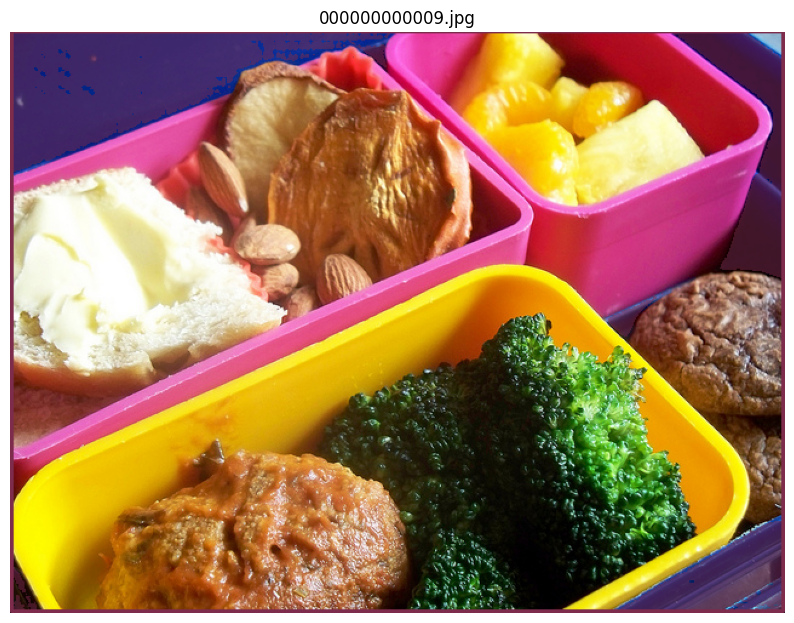

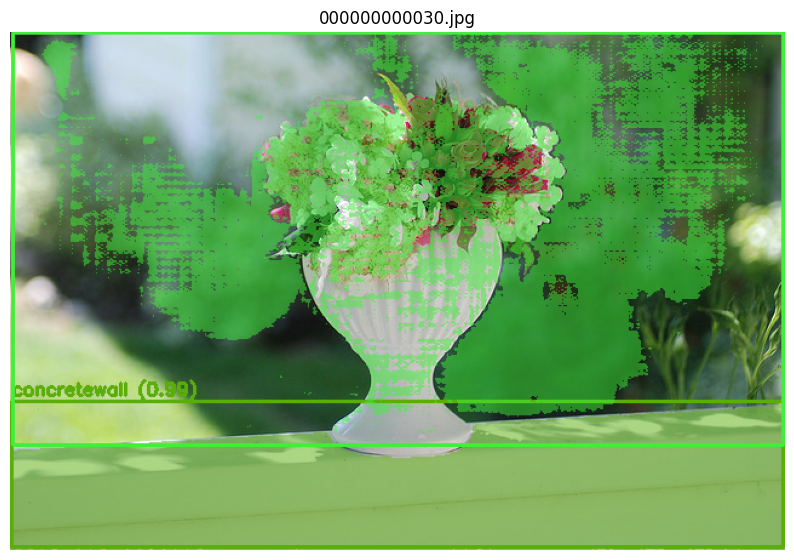

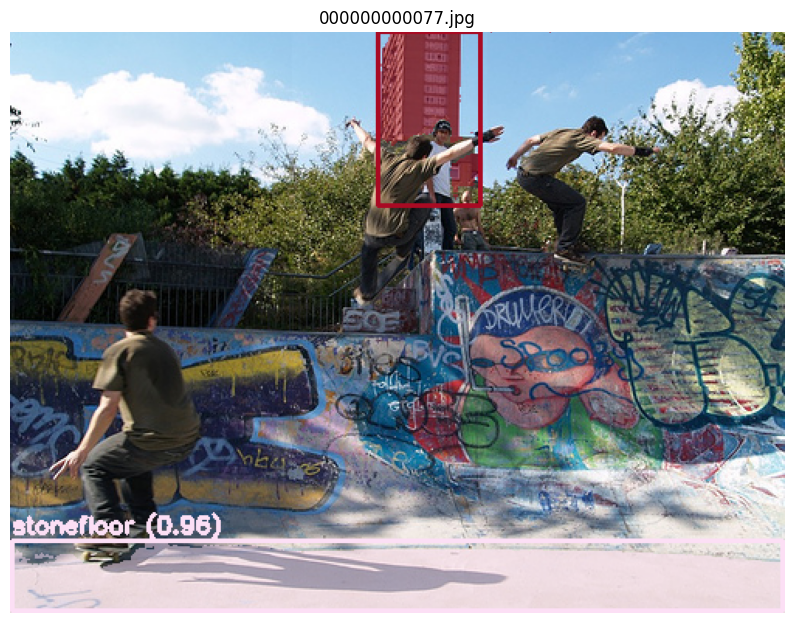

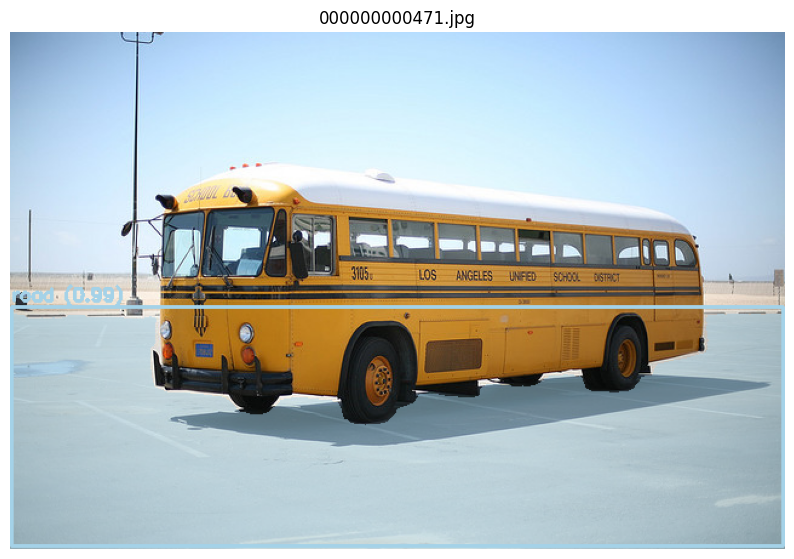

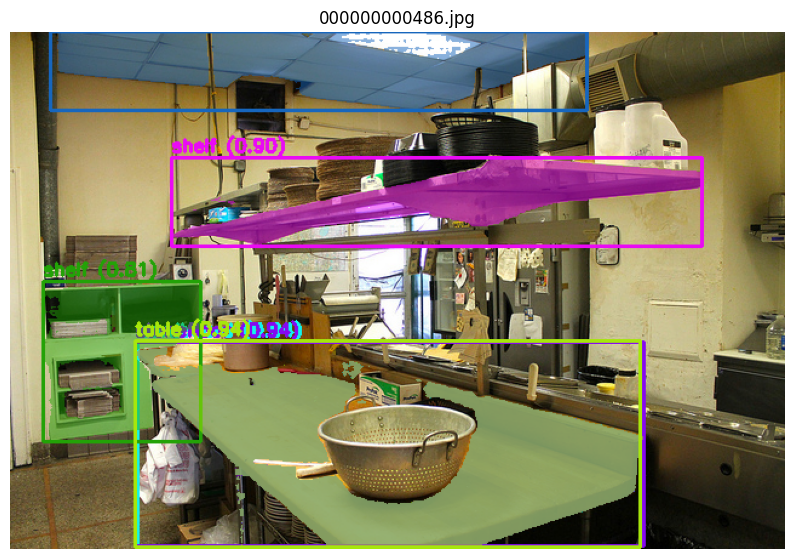

In [15]:
import json
from pathlib import Path
import cv2
from pycocotools import mask as mask_util
import numpy as np
import matplotlib.pyplot as plt

# Load JSON results
with open("outputs/results_stuff/all_image_results.json", "r") as f:
    all_results = json.load(f)

# Function to visualize one image result
def visualize_result(entry):
    image_path = entry["image_path"]
    annotations = entry["annotations"]

    if not Path(image_path).exists():
        print(f"Image not found: {image_path}")
        return

    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Overlay masks and boxes
    for ann in annotations:
        bbox = ann["bbox"]
        class_name = ann["class_name"]
        score = ann["score"]

        # Fix: Unwrap score if it's a list
        if isinstance(score, list):
            score = score[0]

        rle = ann["segmentation"]

        # Decode RLE mask
        mask = mask_util.decode(rle)

        # Create a colored overlay for the mask
        color = np.random.randint(0, 255, (3,), dtype=np.uint8)
        image[mask == 1] = image[mask == 1] * 0.5 + color * 0.5

        # Draw bounding box
        x1, y1, x2, y2 = map(int, bbox)
        cv2.rectangle(image, (x1, y1), (x2, y2), color.tolist(), 2)

        # Draw label
        label = f"{class_name} ({score:.2f})"
        cv2.putText(image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 2)

    # Show result
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.title(Path(image_path).name)
    plt.show()

# Visualize first 5 images
for result in all_results[:5]:
    visualize_result(result)
